# Exercise numpy
The ultimate goal of this exercise is to compare the position of stars in a patch of sky as measured in two different surveys. The main task at hand is to identify matching positions of stars between the surveys. For this, we will need to compare the positions of all stars in one survey to the position of all stars in the other survey. This task can be extremely time consuming if not implemented properly, we will therefore use this to compare different coding style and their impact on computation time. 

If time allows, we will move on to represent the results of our analysis in a meaningfull way.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt #We might need this


In [16]:
#First, let us load the data
#Catalog from HSC 
cat_hsc = np.loadtxt('./Catalog_HSC.csv')
ra_hsc = cat_hsc[:,0]
dec_hsc = cat_hsc[:,1]
#Catalog from HST
cat_hst = np.loadtxt('./Catalog_HST.csv')
ra_hst = cat_hst[:,0]
dec_hst = cat_hst[:,1]

Check that the loaded data are consistent with what we expect: (ra, dec) coordinates of the same patch of sky

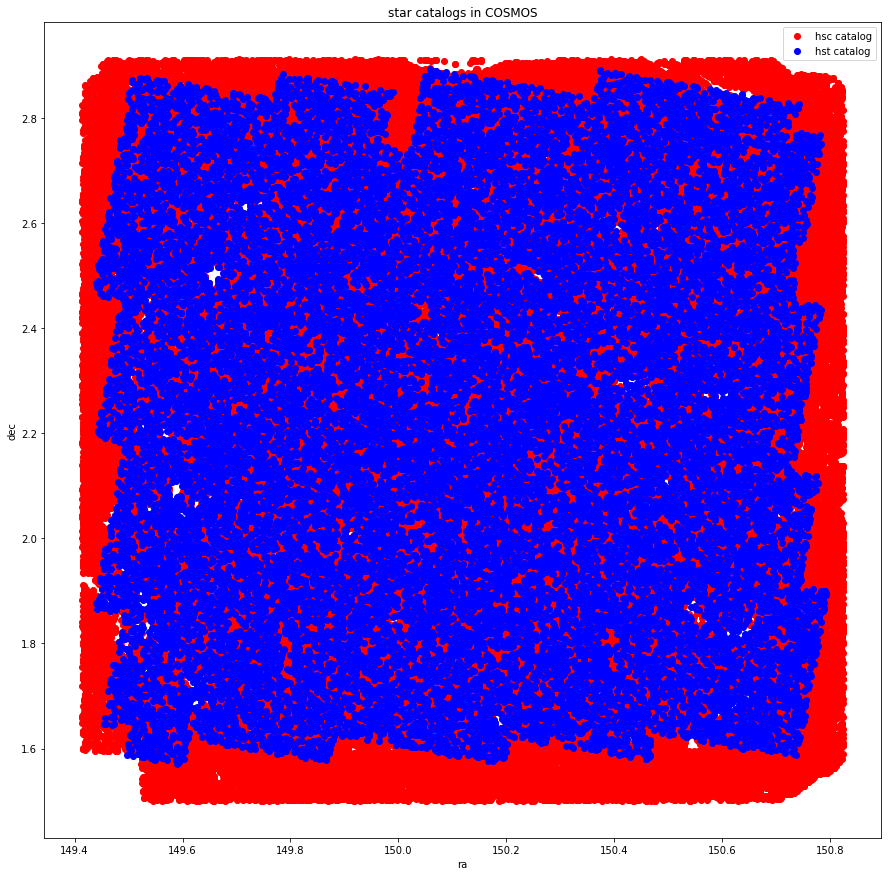

In [32]:
#This is a graphic representation of our data content:
%matplotlib inline
plt.figure(figsize=(15,15))
plt.title('star catalogs in COSMOS')
plt.plot(ra_hsc, dec_hsc, 'or', label = 'hsc catalog')
plt.plot(ra_hst, dec_hst, 'ob', label = 'hst catalog')
plt.legend()
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

Now let's get to work. We would like to associate stars in one survey to their conterpart (if it exists) in the other survey. We will start by comparing the positions between each point of one survey to the position of each point in the other survey.

First, write a function that takes two sets of coordinates (hsc and hst) and returns the distance from each point of one survey to each point of the other, such that the output should be an array of size (n_hst x n_hsc) or (n_hsc x n_hst).

PS: if you have several (different) ideas about how to implement this, feel free to code them!

In [33]:
def dist(coord1, coord2):
    ''' Returns the distance between points in two sets of coordinates.
     
    Parameters
    coord1: array
        array of size Nx2 that contains the [Ra, Dec] positions of a catalog 
    coord2: array
        array of size Mx2 that contains the [Ra, Dec] positions of a catalog 
    
    Returns
    dist: array
        array of size NxM that contains the euclidean distances between points in the two datasets
    '''
    
    return 


Now, let us take a look at the computation times:

In [38]:
# In order not to spend the whole evening here, let us reduce the dataset size:
#Select stars in hsc in the frame: 150.0<ra<150.1 and 2.0<dec<2.1
loc_hsc = (np.abs(dec_hsc-2.05)<0.2)*(np.abs(ra_hsc-150.05)<0.2)
ra_hsc_exp = ra_hsc[loc_hsc]
dec_hsc_exp = dec_hsc[loc_hsc]

loc_hst = (np.abs(dec_hst-2.05)<0.2)*(np.abs(ra_hst-150.05)<0.2)
ra_hst_exp = ra_hst[loc_hst]
dec_hst_exp = dec_hst[loc_hst]

print(f'size of hst catalog: {np.size(ra_hst[loc_hst])} objects')
print(f'size of hsc catalog: {np.size(ra_hsc[loc_hsc])} objects')
#Once you are done with the exercise, feel free to try with larger selections to see how it impacts computation time

size of hst catalog: 2870 objects
size of hsc catalog: 20938 objects


In [ ]:
import distances as dt
# Insert the names of your functions in the following array:
methods = [dist, dt.naive, dt.with_indices, dt.one_loop, dt.one_loop_reverse, dt.scipy_version, dt.newaxis_magic]
#An empty variable to store computation time
timers = []
c2 = np.concatenate((ra_hst_exp[:,None], dec_hst_exp[:,None]), axis = 1)#Please fill these
c1 = np.concatenate((ra_hsc_exp[:,None], dec_hsc_exp[:,None]), axis = 1)

for f in methods:
    r = %timeit -o f(c1, c2)
    timers.append(r)

78.9 ns ± 2.39 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


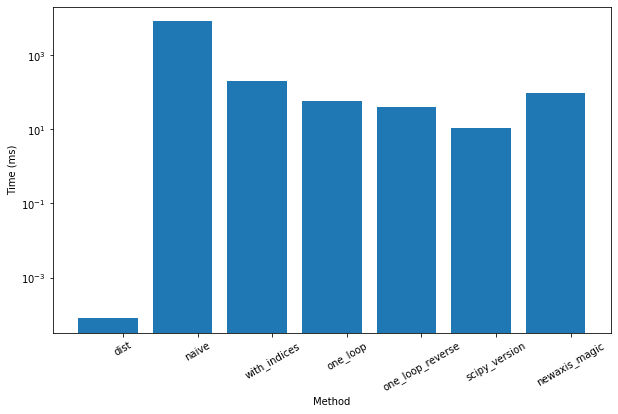

In [37]:
#View the results:
plt.figure(figsize=(10,6))
plt.bar(np.arange(len(methods)), [r.best*1000 for r in timers], log=True)  # Set log to True for logarithmic scale
plt.xticks(np.arange(len(methods))+0.2, [f.__name__ for f in methods], rotation=30)
plt.xlabel('Method')
plt.ylabel('Time (ms)')
plt.show()

# Identifying matching stars
Now that we know all the distances, let us find the stars in each datasets that correspond to one another.
This is done by finding, for each star, the minimum distance recorded between the two datasets.

One problem that arises with deriving an array that computes all the distances is that we end up with a very LARGE array, which becomes impractical for fast computations. Instead, we will modify one of the previous functions so that it returns the coordinates of stars that have a match in both datasets along with their distance.

Because all stars in a given set do not have a counter part in the other, we will only accept a match if the minimum distance between two points is smaller than 0.17 arcseconds (the size of an HSC pixel).

In other words, for each star in one dataset, find the star in the other dataset that is the closest (minimum distance), check wether that star is closer that 0.17 arcseconds, if yes, store its coordinates along with the computed distance. At the end of the function, return arrays with the matching star coordinates and their distance to their match in the other dataset.

In [27]:
#Let us compute the distances as we did before, but this time, with the whole dataset.
#Of course, a fast method is to be prefered

c1 = np.concatenate((ra_hst[:,None], dec_hst[:,None]), axis = 1)#Please fill these
c2 = np.concatenate((ra_hsc[:,None], dec_hsc[:,None]), axis = 1)



In [28]:
def get_match(coord_ref, coord2, rad):
    '''
    matches coordinates of stars between two datasets and computes the distance between the position of the stars in the 2 datasets

    Parameters
    coord_ref: numpy array (Nx2)
        coordinates (ra, dec) of stars in a FoV from a given dataset
    coord2: numpy array (Mx2)
        coordinates (ra dec) of stars in the same FoV in an other dataset
    rad: float
        radius (deg) around stars in coord_ref where to find a corresponding star in coord2
            
    Returns
    modulus:numpy array (N')
        containing the distance between matching stars
    v_coord: numpy array(N',2)
        coordinates in the coord_ref set of matching stars
            

    '''
    #Declare two empty arrays to store the coordinates and distances.
    modulus = []
    v_coord = []
    angle = []
    s = np.size(coord_ref[:,0])
    print('number of points in reference catalog: {0}'.format(s))
    #for each star in coord_ref
    for i,c in enumerate(coord_ref):

        if i % 3000 == 0:
            print('point number {0} out of {1}'.format(i, s))
        #compute the distance to all stars in coord2
        r = ((c[0]-coord2[:,0])**2+(c[1]-coord2[:,1])**2)**0.5
        #Find the closest star from coord 2 to c
        loc = np.array(np.where(r == np.min(r))).flatten()

        #Make sure that there is only one star matching
        if np.size(loc) > 1:
            loc = loc[0]

        #record the distance between matching stars
        rmin = r[loc]
        
        #Check whether the closest distance is smaller than rad
        if rmin <= rad:
            #if yes, save the coordinates and the distance in an array
            v_coord.append(c)
            modulus.append(rmin.item())
            angle.append(np.arctan2(-c[0]+coord2[loc,0], -c[1]+coord2[loc,1]).item())

    return np.array(v_coord), np.array(modulus), np.array(angle)

In [29]:
# Use your function 
coord , r = get_match(c1, c2, 0.3/3600.)

number of points in reference catalog: 28109
point number 0 out of 28109
point number 3000 out of 28109
point number 6000 out of 28109
point number 9000 out of 28109
point number 12000 out of 28109
point number 15000 out of 28109
point number 18000 out of 28109
point number 21000 out of 28109
point number 24000 out of 28109
point number 27000 out of 28109


ValueError: too many values to unpack (expected 2)

Now I would like to have a representation for the work we have done that informs me about what is in my datasets. Namely, what is the error on star positions between the two datasets? We would like to have a global view of this error but also an impression of the error as a function of the position on the field. For the latter, I suggest you use the 'scatter' function from matplotlib.


In [ ]:
#Spatial distribution of distances
plt.figure(0)
plt.title('distribution of distances accross the FoV')
plt.scatter(coord[:,0],coord[:,1],c = r, cmap = 'gist_stern')
plt.xlabel('ra')
plt.ylabel('dec')
plt.colorbar()
plt.show()

plt.figure(1)
plt.title('distribution of angles accross the FoV')
plt.scatter(coord[:,0],coord[:,1],c = theta, cmap = 'twilight')
plt.xlabel('ra')
plt.ylabel('dec')
plt.colorbar()
plt.show()